ARIMA Project for beverage sales

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [4]:
# Load dataset
df = pd.read_csv(r'C:\Users\faizm\OneDrive\Desktop\UNF STUDY METERIAL\Sem 2\predictive analysis\arima project\synthetic_beverage_sales_data.csv')

EDA

In [5]:
df.columns
df.shape
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8999910 entries, 0 to 8999909
Data columns (total 11 columns):
 #   Column         Dtype  
---  ------         -----  
 0   Order_ID       object 
 1   Customer_ID    object 
 2   Customer_Type  object 
 3   Product        object 
 4   Category       object 
 5   Unit_Price     float64
 6   Quantity       int64  
 7   Discount       float64
 8   Total_Price    float64
 9   Region         object 
 10  Order_Date     object 
dtypes: float64(3), int64(1), object(7)
memory usage: 755.3+ MB


,Unit_Price,Quantity,Discount,Total_Price
count,8.999910e+06,8.999910e+06,8.999910e+06,8.999910e+06
mean,5.818037e+00,2.313813e+01,2.972879e-02,1.307437e+02
std,1.470050e+01,2.689321e+01,4.479841e-02,5.096947e+02
min,3.200000e-01,1.000000e+00,0.000000e+00,3.000000e-01
25%,1.050000e+00,6.000000e+00,0.000000e+00,8.400000e+00
50%,1.750000e+00,1.100000e+01,0.000000e+00,2.114000e+01
75%,3.210000e+00,3.000000e+01,5.000000e-02,6.949000e+01
max,1.695300e+02,1.000000e+02,1.500000e-01,1.429530e+04


##checking for duplicates

In [6]:
duplicates= df[df.duplicated(subset= ['Order_ID', 'Customer_ID', 'Customer_Type', 'Product', 'Category',
       'Unit_Price', 'Quantity', 'Discount', 'Total_Price', 'Region','Order_Date'], keep='first')]

len(duplicates)

0

##Remove missing values

In [7]:
import statsmodels.formula.api as smf

# Detect missing values
missing_values = df.isnull().sum()
print("Missing Values:\n", missing_values)

Missing Values:
 Order_ID         0
Customer_ID      0
Customer_Type    0
Product          0
Category         0
Unit_Price       0
Quantity         0
Discount         0
Total_Price      0
Region           0
Order_Date       0
dtype: int64


In [8]:
df.head()

,Order_ID,Customer_ID,Customer_Type,Product,Category,Unit_Price,Quantity,Discount,Total_Price,Region,Order_Date
0,ORD1,CUS1496,B2B,Vio Wasser,Water,1.66,53,0.10,79.18,Baden-Württemberg,2023-08-23
1,ORD1,CUS1496,B2B,Evian,Water,1.56,90,0.10,126.36,Baden-Württemberg,2023-08-23
2,ORD1,CUS1496,B2B,Sprite,Soft Drinks,1.17,73,0.05,81.14,Baden-Württemberg,2023-08-23
3,ORD1,CUS1496,B2B,Rauch Multivitamin,Juices,3.22,59,0.10,170.98,Baden-Württemberg,2023-08-23
4,ORD1,CUS1496,B2B,Gerolsteiner,Water,0.87,35,0.10,27.40,Baden-Württemberg,2023-08-23


## Feature selection and optimization

In [9]:
# Convert 'Order_Date' to datetime format
df['Order_Date'] = pd.to_datetime(df['Order_Date'])


In [10]:
# Verify the change
print(df.dtypes)

Order_ID                 object
Customer_ID              object
Customer_Type            object
Product                  object
Category                 object
Unit_Price              float64
Quantity                  int64
Discount                float64
Total_Price             float64
Region                   object
Order_Date       datetime64[ns]
dtype: object


In [11]:
# Set 'Order_Date' as index for future use
df.set_index('Order_Date', inplace=True)
print('Order_Date has been set as index')


Order_Date has been set as index


In [12]:
df=df[['Total_Price']]
df.columns = ['Total_Price']
print(df.head())

            Total_Price
Order_Date             
2023-08-23        79.18
2023-08-23       126.36
2023-08-23        81.14
2023-08-23       170.98
2023-08-23        27.40


In [13]:
# Aggregate monthly sales (Month-End)
df = df.resample('ME').sum()
print("Data after resampling:")
print(df.head())  # Check the time series structure

Data after resampling:
            Total_Price
Order_Date             
2021-01-31  32425429.08
2021-02-28  29110169.14
2021-03-31  32957436.50
2021-04-30  31142058.64
2021-05-31  31855490.12


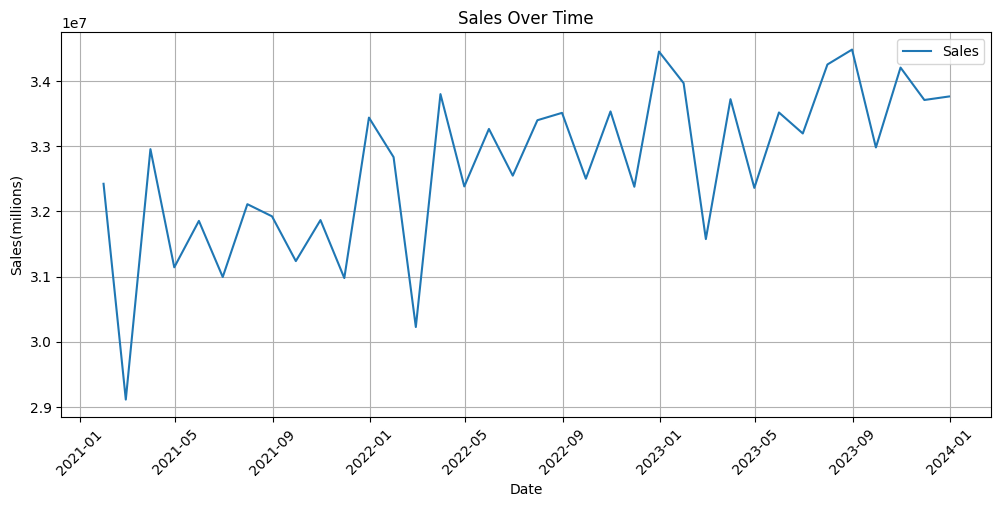

In [14]:
# ploting monthly sales in a line graph
plt.figure(figsize=(12, 5))
plt.plot(df['Total_Price'], label='Sales')
plt.xlabel('Date')
plt.ylabel('Sales(millions)')
plt.title('Sales Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

## adfuler test for stationality

In [15]:
# Checking stationarity using Augmented Dickey-Fuller test
result = adfuller(df['Total_Price'].dropna())  # Run the test

# Print ADF Statistic and p-value
print("ADF Statistic:", result[0])
print("p-value:", result[1])

# Interpretation of the result
if result[1] < 0.05:
    print("The time series is stationary (p-value < 0.05).")
else:
    print("The time series is not stationary (p-value >= 0.05).")

ADF Statistic: -0.789334335601163
p-value: 0.8222349672084712
The time series is not stationary (p-value >= 0.05).


In [16]:
# Shiftting data to make it stationary. --first attempt
df['Total_Price_firstdiff']=df['Total_Price']-df['Total_Price'].shift(1)
df.head(10)

,Total_Price,Total_Price_firstdiff
Order_Date,,
2021-01-31,32425429.08,NaN
2021-02-28,29110169.14,-3315259.94
2021-03-31,32957436.50,3847267.36
2021-04-30,31142058.64,-1815377.86
2021-05-31,31855490.12,713431.48
2021-06-30,30993287.36,-862202.76
2021-07-31,32112059.34,1118771.98
2021-08-31,31925599.31,-186460.03
2021-09-30,31237668.17,-687931.14


In [17]:
#Checking the result of shifting data by 1 with adfuller test
result1 = adfuller(df['Total_Price_firstdiff'].dropna())
print("ADF Statistic:", result1[0])
print("p-value:", result1[1])
if result1[1] < 0.05:
    print("The time series is stationary (p-value < 0.05).")
else:
    print("The time series is not stationary (p-value >= 0.05).")

ADF Statistic: -2.365047824491891
p-value: 0.1518453238732821
The time series is not stationary (p-value >= 0.05).


In [18]:
# Second difference by addint one more shift to the previously executed data
df['Total_Price_seconddiff'] = df['Total_Price_firstdiff'].diff().dropna()

# Run ADF test
result2 = adfuller(df['Total_Price_seconddiff'].dropna())
print("ADF Statistic (2nd diff):", result2[0])
print("p-value:", result2[1])
print("Critical Values:", result2[4])
if result2[1] < 0.05:
    print("The 2nd differenced series is stationary (p-value < 0.05).")
else:
    print("The 2nd differenced series is not stationary (p-value >= 0.05).")

ADF Statistic (2nd diff): -2.1794436381795803
p-value: 0.2137906377449158
Critical Values: {'1%': np.float64(-3.7529275211638033), '5%': np.float64(-2.998499866852963), '10%': np.float64(-2.6389669754253307)}
The 2nd differenced series is not stationary (p-value >= 0.05).


In [19]:
# Seasonal difference (lag=12) 
df['Total_Price_seasondiff'] = df['Total_Price'] - df['Total_Price'].shift(12)
df_seasondiff = df['Total_Price_seasondiff'].dropna()

# Run ADF test
from statsmodels.tsa.stattools import adfuller
result = adfuller(df_seasondiff)
print("ADF Statistic (seasonal diff):", result[0])
print("p-value:", result[1])
print("Critical Values:", result[4])
if result[1] < 0.05:
    print("The seasonally differenced series is stationary (p-value < 0.05).")
else:
    print("The seasonally differenced series is not stationary (p-value >= 0.05).")

ADF Statistic (seasonal diff): -1.3108709703252044
p-value: 0.6241842723318127
Critical Values: {'1%': np.float64(-4.01203360058309), '5%': np.float64(-3.1041838775510207), '10%': np.float64(-2.6909873469387753)}
The seasonally differenced series is not stationary (p-value >= 0.05).


In [20]:
# Seasonal difference (lag=12)
df['Total_Price_seasondiff'] = df['Total_Price'] - df['Total_Price'].shift(12)

# Then apply first difference (lag=1) to the seasonally differenced series
df['Total_Price_season_firstdiff'] = df['Total_Price_seasondiff'].diff().dropna()

# Run ADF test
from statsmodels.tsa.stattools import adfuller
result = adfuller(df['Total_Price_season_firstdiff'].dropna())
print("ADF Statistic (seasonal + first diff):", result[0])
print("p-value:", result[1])
print("Critical Values:", result[4])
if result[1] < 0.05:
    print("The combined differenced series is stationary (p-value < 0.05).")
else:
    print("The combined differenced series is not stationary (p-value >= 0.05).")

ADF Statistic (seasonal + first diff): -3.8936310406349492
p-value: 0.002082222339202885
Critical Values: {'1%': np.float64(-3.7883858816542486), '5%': np.float64(-3.013097747543462), '10%': np.float64(-2.6463967573696143)}
The combined differenced series is stationary (p-value < 0.05).


Length of differenced series: 23


<Figure size 1200x400 with 0 Axes>

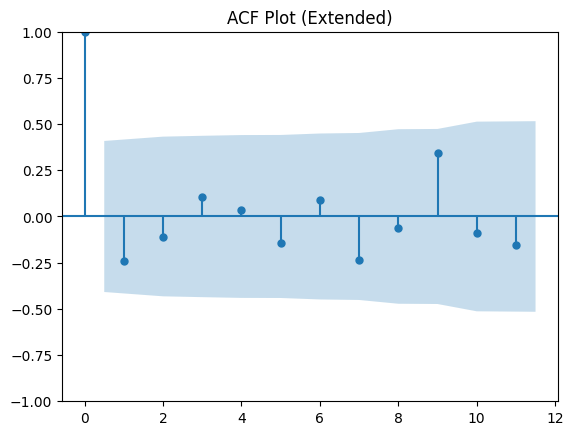

<Figure size 1200x400 with 0 Axes>

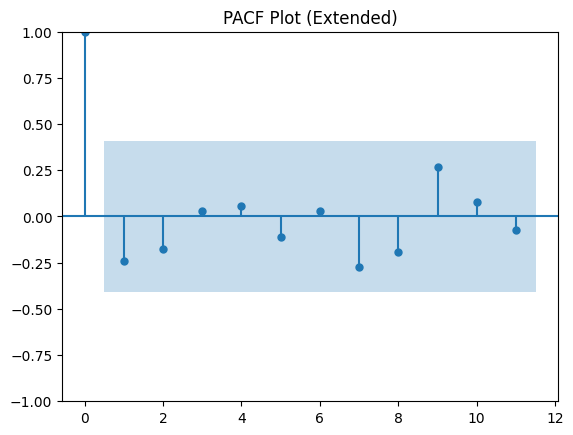

In [21]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Check the length of your series
print("Length of differenced series:", len(df['Total_Price_season_firstdiff'].dropna()))

# Set lags to include seasonal period (12) and a few more
max_lags = min(24, len(df['Total_Price_season_firstdiff'].dropna()) // 2)  # Ensure < 50% of length

# ACF plot
plt.figure(figsize=(12, 4))
plot_acf(df['Total_Price_season_firstdiff'].dropna(), lags=max_lags)
plt.title('ACF Plot (Extended)')
plt.show()

# PACF plot
plt.figure(figsize=(12, 4))
plot_pacf(df['Total_Price_season_firstdiff'].dropna(), lags=max_lags)
plt.title('PACF Plot (Extended)')
plt.show()

In [22]:
#done log atransform to remove varience and make it more stationary
df['Log_Total_Price'] = np.log(df['Total_Price'])
# Fit SARIMA(0,1,0)(0,1,0,12) - no AR or MA terms, just differencing
model = sm.tsa.SARIMAX(df['Log_Total_Price'], 
                       order=(0, 1, 0),              # p=0, d=1, q=0
                       seasonal_order=(0, 1, 0, 12)) # P=0, D=1, Q=0, s=12
results = model.fit()
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                    Log_Total_Price   No. Observations:                   36
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 12)   Log Likelihood                  58.313
Date:                            Wed, 05 Mar 2025   AIC                           -114.627
Time:                                    06:25:30   BIC                           -113.491
Sample:                                01-31-2021   HQIC                          -114.341
                                     - 12-31-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0004   6.83e-05      5.380      0.000       0.000       0.001
Ljung-Box (L1) (Q):                

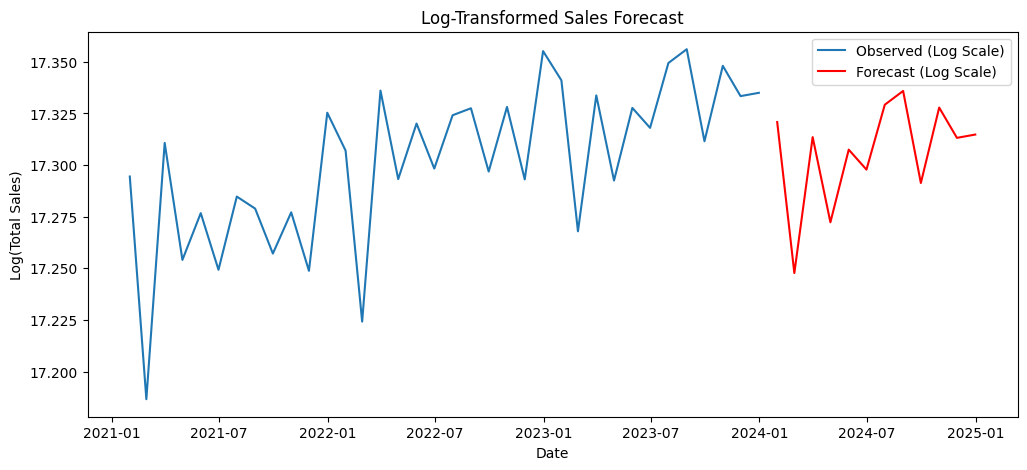

Forecasted Total Sales (original scale):
2024-01-31    3.329222e+07
2024-02-29    3.094450e+07
2024-03-31    3.305017e+07
2024-04-30    3.171488e+07
2024-05-31    3.285014e+07
2024-06-30    3.253419e+07
2024-07-31    3.357279e+07
2024-08-31    3.379723e+07
2024-09-30    3.232369e+07
2024-10-31    3.352636e+07
2024-11-30    3.303829e+07
2024-12-31    3.309108e+07
Freq: ME, Name: predicted_mean, dtype: float64


In [23]:
# Forecast 12 months ahead
forecast_steps = 12
forecast = results.forecast(steps=forecast_steps)

# Create date index for forecast
last_date = df.index[-1]
forecast_index = pd.date_range(start=last_date, periods=forecast_steps + 1, freq='ME')[1:]

# Plot
plt.figure(figsize=(12, 5))
plt.plot(df['Log_Total_Price'], label='Observed (Log Scale)')
plt.plot(forecast_index, forecast, label='Forecast (Log Scale)', color='red')
plt.title('Log-Transformed Sales Forecast')
plt.xlabel('Date')
plt.ylabel('Log(Total Sales)')
plt.legend()
plt.show()

# Convert forecast back to original scale (exponential)
forecast_original = np.exp(forecast)
print("Forecasted Total Sales (original scale):")
print(pd.Series(forecast_original, index=forecast_index))

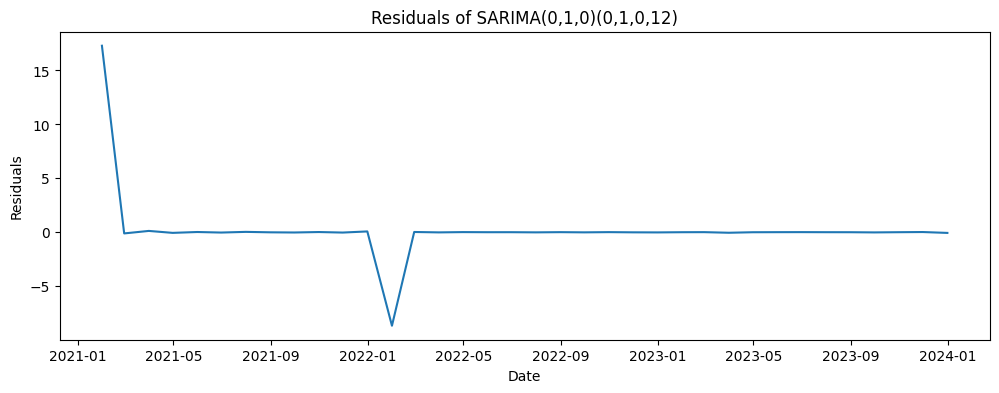

In [24]:
## ploting residual for the final SARIMA (0, 1, 0)(0, 1, 0, 12)
residuals = results.resid  # From your fitted SARIMA(0,1,0)(0,1,0,12) model
plt.figure(figsize=(12, 4))
plt.plot(residuals)
plt.title('Residuals of SARIMA(0,1,0)(0,1,0,12)')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.show()

Order_Date
2022-09-30    17.296863
2022-10-31    17.328148
2022-11-30    17.293045
2022-12-31    17.355198
Freq: ME, Name: Log_Total_Price, dtype: float64
Order_Date
2022-09-30    32503656.55
2022-10-31    33536594.33
2022-11-30    32379794.64
2022-12-31    34456160.95
Freq: ME, Name: Total_Price, dtype: float64


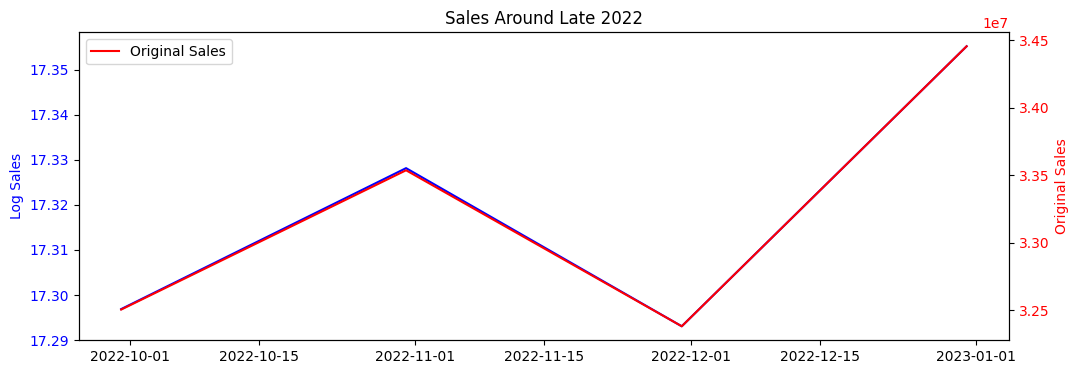

In [25]:
# Check the log-transformed and original data around late 2022
print(df['Log_Total_Price']['2022-09-30':'2022-12-31'])
print(df['Total_Price']['2022-09-30':'2022-12-31'])

# Optionally, plot this period

# Plotting with two y-axes
plt.figure(figsize=(12, 4))
ax1 = plt.gca()  # Primary axis for Log_Total_Price
ax2 = ax1.twinx()  # Secondary axis for Total_Price

# Plot Log_Total_Price on primary y-axis
ax1.plot(df['Log_Total_Price']['2022-09-30':'2022-12-31'], label='Log Sales', color='blue')
ax1.set_ylabel('Log Sales', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Plot Total_Price on secondary y-axis
ax2.plot(df['Total_Price']['2022-09-30':'2022-12-31'], label='Original Sales', color='red')
ax2.set_ylabel('Original Sales', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Sales Around Late 2022')
plt.xlabel('Date')
plt.legend()
plt.show()

In [26]:
# Create dummy for Dec 2022
df['Dec_2022_dummy'] = (df.index.month == 12) & (df.index.year == 2022)
df['Dec_2022_dummy'] = df['Dec_2022_dummy'].astype(int)

# Fit model with dummy
model = sm.tsa.SARIMAX(df['Log_Total_Price'], 
                       order=(0, 1, 0), 
                       seasonal_order=(0, 1, 0, 12),
                       exog=df['Dec_2022_dummy'])
results = model.fit()
print(results.summary())

# Re-forecast with the updated model

# Assuming 'df' and 'results' are already defined from your SARIMA fit
forecast_steps = 12
forecast_index = pd.date_range(start=df.index[-1], periods=forecast_steps + 1, freq='ME')[1:]  # Use 'ME' for Month-End
exog_forecast = pd.Series(0, index=forecast_index)  # 12 zeros for 12 months

# Re-forecast with the updated model
forecast = results.forecast(steps=forecast_steps, exog=exog_forecast)
forecast_original = np.exp(forecast)
print("Forecasted Total Sales (original scale, with Dec 2022 dummy):")
print(pd.Series(forecast_original, index=forecast_index))

                                     SARIMAX Results                                      
Dep. Variable:                    Log_Total_Price   No. Observations:                   36
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 12)   Log Likelihood                  59.141
Date:                            Wed, 05 Mar 2025   AIC                           -114.282
Time:                                    06:25:36   BIC                           -112.011
Sample:                                01-31-2021   HQIC                          -113.711
                                     - 12-31-2023                                         
Covariance Type:                              opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Dec_2022_dummy     0.0140      0.007      2.109      0.035       0.001       0.027
sigma2             0.00

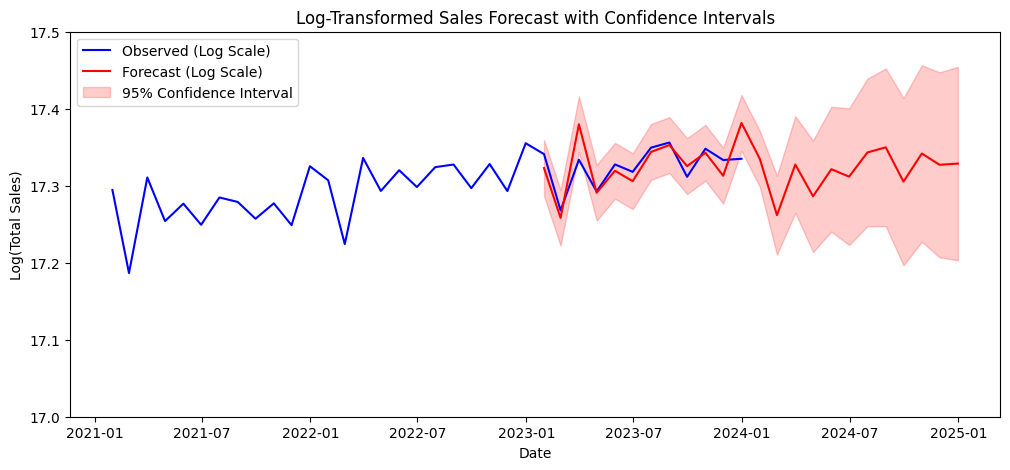

Forecasted Total Sales (original scale, Jan 2024 - Dec 2024):
                    Mean  Lower 95% CI  Upper 95% CI
2024-01-31  3.376117e+07  3.255960e+07  3.500708e+07
2024-02-29  3.138039e+07  2.981267e+07  3.303055e+07
2024-03-31  3.351571e+07  3.147667e+07  3.568685e+07
2024-04-30  3.216161e+07  2.991307e+07  3.457918e+07
2024-05-31  3.331287e+07  3.071990e+07  3.612470e+07
2024-06-30  3.299247e+07  3.019004e+07  3.605503e+07
2024-07-31  3.404569e+07  3.093302e+07  3.747159e+07
2024-08-31  3.427330e+07  3.093435e+07  3.797265e+07
2024-09-30  3.277901e+07  2.940225e+07  3.654357e+07
2024-10-31  3.399861e+07  3.031740e+07  3.812681e+07
2024-11-30  3.350367e+07  2.970940e+07  3.778251e+07
2024-12-31  3.355720e+07  2.959826e+07  3.804566e+07


In [27]:
# Assuming 'results', 'df', and 'forecast_index' are defined
forecast_steps = 12
forecast_index = pd.date_range(start=df.index[-1], periods=forecast_steps + 1, freq='ME')[1:]
exog_forecast = pd.Series(0, index=forecast_index)

# Get prediction with confidence intervals
pred = results.get_prediction(start=len(df) - 12, end=len(df) + 11, exog=exog_forecast)
pred_ci = pred.conf_int()

# Plot with correct y-axis scale for log-transformed data
plt.figure(figsize=(12, 5))
plt.plot(df['Log_Total_Price'], label='Observed (Log Scale)', color='blue')
plt.plot(pred_ci.index, pred.predicted_mean, label='Forecast (Log Scale)', color='red')  # Use pred.predicted_mean directly
plt.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='red', alpha=0.2, label='95% Confidence Interval')
plt.title('Log-Transformed Sales Forecast with Confidence Intervals')
plt.xlabel('Date')
plt.ylabel('Log(Total Sales)')
plt.ylim(17.0, 17.5)  # Set y-axis limits to match your log scale (~17.2 to 17.35)
plt.legend()
plt.show()

# Print forecast in original scale with confidence intervals
forecast_mean = np.exp(pred.predicted_mean[-forecast_steps:])
forecast_lower = np.exp(pred_ci.iloc[-forecast_steps:, 0])
forecast_upper = np.exp(pred_ci.iloc[-forecast_steps:, 1])

print("Forecasted Total Sales (original scale, Jan 2024 - Dec 2024):")
print(pd.DataFrame({
    'Mean': forecast_mean,
    'Lower 95% CI': forecast_lower,
    'Upper 95% CI': forecast_upper
}, index=forecast_index))




In [28]:
forecast_df = pd.DataFrame({
    'Mean': forecast_mean,
    'Lower 95% CI': forecast_lower,
    'Upper 95% CI': forecast_upper
}, index=forecast_index)
forecast_df.to_csv('forecasted_sales_2024.csv')
print('saved as forecasted_sales_2024.csv')

saved as forecasted_sales_2024.csv


Actual Original Scale Sample (Millions):
Order_Date
2021-01-31    32.425429
2021-02-28    29.110169
2021-03-31    32.957437
2021-04-30    31.142059
2021-05-31    31.855490
Freq: ME, Name: Log_Total_Price, dtype: float64

Predicted Original Scale Sample (Millions):
Order_Date
2021-01-31    32.425429
2021-02-28    32.425429
2021-03-31    29.110169
2021-04-30    32.957437
2021-05-31    31.142059
Freq: ME, Name: predicted_mean, dtype: float64

Model Performance Metrics (Original Scale, Millions):
MAE (Original Scale, Millions): $5289.62M
MSE (Original Scale, Millions): $1006991599.87T
RMSE (Original Scale, Millions): $31733.13M
MAPE (Original Scale): 16109.82%


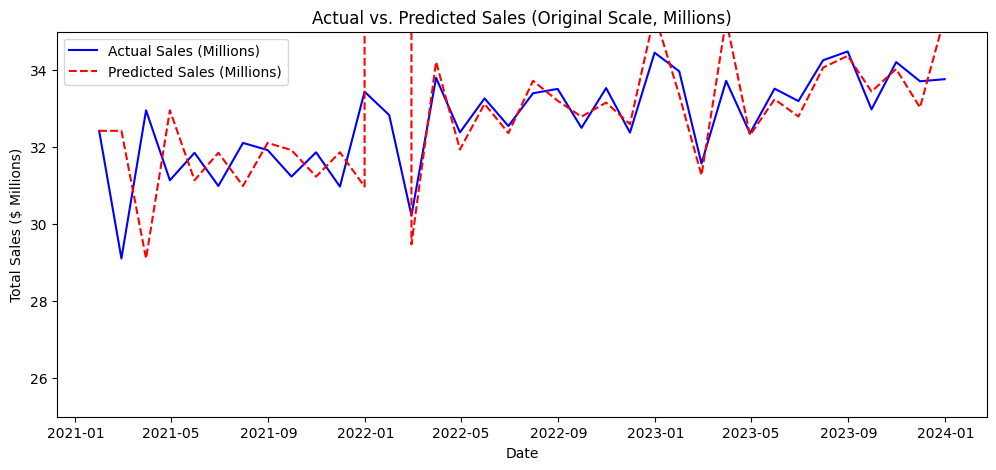

In [29]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Assuming 'df' and 'results' are already defined
df['Dec_2022_dummy'] = (df.index.month == 12) & (df.index.year == 2022)
df['Dec_2022_dummy'] = df['Dec_2022_dummy'].astype(int)

# Get in-sample predictions, handling the first prediction correctly
pred = results.get_prediction(start=0, end=len(df) - 1, exog=df['Dec_2022_dummy'])
predicted_mean = pred.predicted_mean

# Handle NaN or zero in the first prediction (replace with actual log value or interpolate)
if pd.isna(predicted_mean.iloc[0]) or predicted_mean.iloc[0] == 0:
    predicted_mean.iloc[0] = df['Log_Total_Price'].iloc[0]  # Use actual log value for Jan 2021

# Get actual values
actual_log = df['Log_Total_Price']
actual_original = np.exp(actual_log)  # Exponentiate to original scale (millions, e.g., ~29M to ~34.5M)
predicted_original = np.exp(predicted_mean)  # Exponentiate to original scale

# Verify scaling (ensure values are in millions)
print("Actual Original Scale Sample (Millions):")
print(actual_original.head() / 1e6)  # Should show ~29 to ~34.5
print("\nPredicted Original Scale Sample (Millions):")
print(predicted_original.head() / 1e6)  # Should show similar range, no zeros

# Calculate errors in original scale (millions)
mae_original = mean_absolute_error(actual_original, predicted_original)
mse_original = mean_squared_error(actual_original, predicted_original)
rmse_original = np.sqrt(mse_original)

# Calculate MAPE in original scale
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

mape_original = mean_absolute_percentage_error(actual_original, predicted_original)

# Print results
print("\nModel Performance Metrics (Original Scale, Millions):")
print(f"MAE (Original Scale, Millions): ${mae_original / 1e6:.2f}M")
print(f"MSE (Original Scale, Millions): ${(mse_original / 1e12):.2f}T")
print(f"RMSE (Original Scale, Millions): ${rmse_original / 1e6:.2f}M")
print(f"MAPE (Original Scale): {mape_original:.2f}%")

# Plot with correct scaling (millions)
plt.figure(figsize=(12, 5))
plt.plot(df.index, actual_original / 1e6, label='Actual Sales (Millions)', color='blue')
plt.plot(df.index, predicted_original / 1e6, label='Predicted Sales (Millions)', color='red', linestyle='--')
plt.title('Actual vs. Predicted Sales (Original Scale, Millions)')
plt.xlabel('Date')
plt.ylabel('Total Sales ($ Millions)')
plt.legend()
plt.ylim(25, 35)  # Match your data range (~29M to ~34.5M)
plt.show()

## end of code